In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
color_pallet = sns.color_palette()
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
#!pip install statsmodels

In [4]:
from statsmodels.tsa.stattools import adfuller #Augumented Dickey Fuller Test 
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposing the Series into trend and seasonality
from statsmodels.tsa.stattools import acf , pacf #Observing Auto correlation and partial correlation function
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
# checking first few rows of train df
train_df.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [7]:
# checking first few rows of test df
test_df.head()

,Date,store,product,number_sold
0,2019-01-01,0,0,845
1,2019-01-02,0,0,851
2,2019-01-03,0,0,840
3,2019-01-04,0,0,842
4,2019-01-05,0,0,845


In [8]:
# checking info of our train df
train_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         230090 non-null  object
 1   store        230090 non-null  int64 
 2   product      230090 non-null  int64 
 3   number_sold  230090 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB


In [9]:
train_df.describe()

,store,product,number_sold
count,230090.000000,230090.000000,230090.000000
mean,3.000000,4.500000,780.926107
std,2.000004,2.872288,204.096737
min,0.000000,0.000000,238.000000
25%,1.000000,2.000000,722.000000
50%,3.000000,4.500000,835.000000
75%,5.000000,7.000000,914.000000
max,6.000000,9.000000,1205.000000


### we can see the type of date column is object type,lets change it to correct type

In [10]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
## changing column name from numbers_sold to sold
new_columns = ['Date','Store','Products','Sold']
train_df.columns = new_columns
test_df.columns = new_columns

In [11]:
# different types of stores available inour dataframe
train_df['Store'].value_counts()

0    32870
1    32870
2    32870
3    32870
4    32870
5    32870
6    32870
Name: Store, dtype: int64

In [12]:
# Different types of products available inour dataframe
train_df['Products'].value_counts()

0    23009
1    23009
2    23009
3    23009
4    23009
5    23009
6    23009
7    23009
8    23009
9    23009
Name: Products, dtype: int64

#### Extracting day ,month, year, day of week  from date column

In [13]:
train_df['day']= train_df['Date'].dt.day
train_df['month']= train_df['Date'].dt.month
train_df['year']= train_df['Date'].dt.year
train_df['dayofweek']= train_df['Date'].dt.dayofweek
test_df['day']= test_df['Date'].dt.day
test_df['month']= test_df['Date'].dt.month
test_df['year']= test_df['Date'].dt.year
test_df['dayofweek']= test_df['Date'].dt.dayofweek


In [14]:
train_df.head()

,Date,Store,Products,Sold,day,month,year,dayofweek
0,2010-01-01,0,0,801,1,1,2010,4
1,2010-01-02,0,0,810,2,1,2010,5
2,2010-01-03,0,0,818,3,1,2010,6
3,2010-01-04,0,0,796,4,1,2010,0
4,2010-01-05,0,0,808,5,1,2010,1


## Explanatory Data Analysis

#### Data distribution with respect to Store

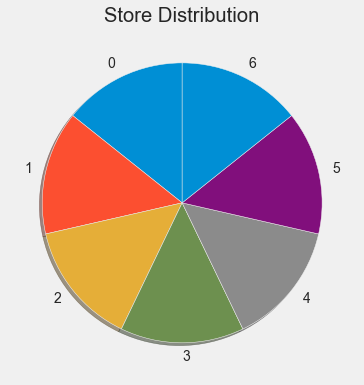

In [15]:
storeNames = train_df["Store"].unique()
storeCount = train_df["Store"].value_counts()

fig1, ax1 = plt.subplots(figsize=(6,6))
plt.pie(storeCount,
        labels=storeNames,
        startangle=90,
        shadow=True)
# Add title to graph
plt.title("Store Distribution")
# Draw the chart
plt.show()

### Store with maximum sales in a particular year

In [16]:
store_sale_yearwise = train_df[['Store','year','Sold']]
store_sale_yearwise.head()

,Store,year,Sold
0,0,2010,801
1,0,2010,810
2,0,2010,818
3,0,2010,796
4,0,2010,808


In [17]:
store_sale_yearwise['year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int64)

##### we can see our year column has 9 unique vales in year, we can use it to plot sales of each store for each year.lets 
##### define a function for the above.

In [18]:
def plot_storesale_year(store):
    """
    This function will take store type as input andcreate a dataframe for each store with thier sold values in each year .
    Then it will plot a line plot for that dataframe.
    """
    store_sale = pd.DataFrame(store_sale_yearwise[store_sale_yearwise['Store']==store].\
                      groupby('year').sum(['Sold']).reset_index())
    plt.figure(figsize =(8,6))
    store_sale.plot(x= 'year',y = 'Sold')
    plt.title('Plot of Amount Sold Each Year by Store {}'.format(store))
    plt.xlabel('Year',fontsize=14)
    plt.ylabel("Amount Sold",fontsize =14)
    plt.show();

<Figure size 576x432 with 0 Axes>

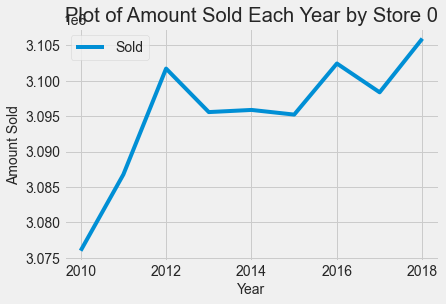

<Figure size 576x432 with 0 Axes>

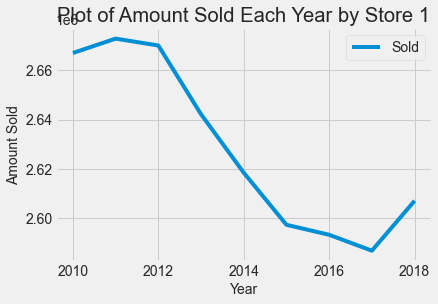

<Figure size 576x432 with 0 Axes>

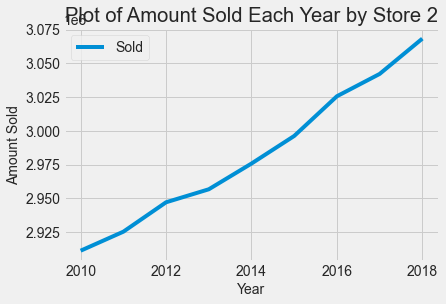

<Figure size 576x432 with 0 Axes>

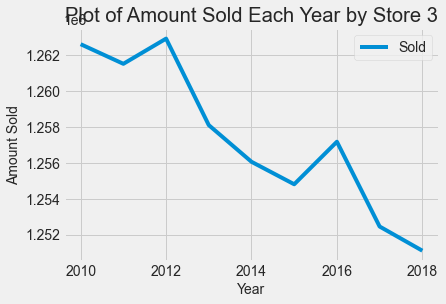

<Figure size 576x432 with 0 Axes>

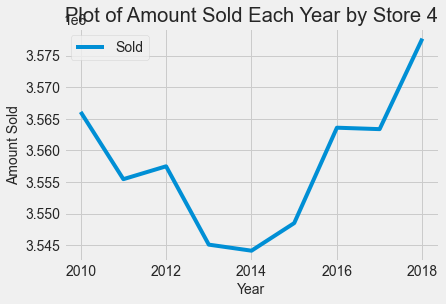

<Figure size 576x432 with 0 Axes>

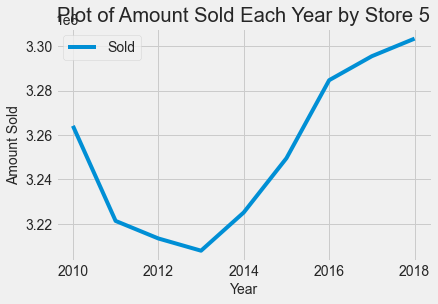

<Figure size 576x432 with 0 Axes>

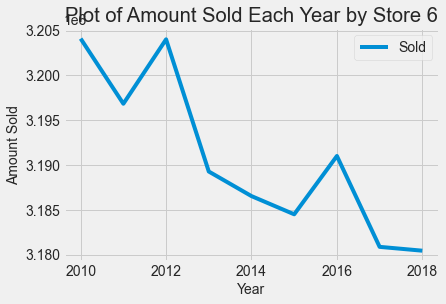

In [19]:
for i in range(train_df['Store'].nunique()):
    plot_storesale_year(i)
    print('')

### Which store has minimum and maximum sales?

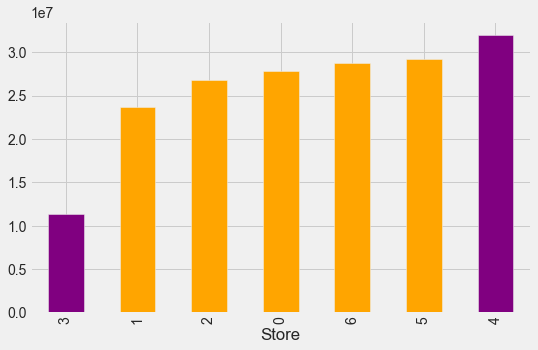

In [20]:
plt.figure(figsize = (8,5))

# Sum weekly sales for each store ,then sorted by total sales
total_sales_for_each_store = train_df.groupby('Store')['Sold'].sum().sort_values()
total_sales_for_each_store_array = np.array(total_sales_for_each_store)  # convert to array

# Assigning a specific color for the stores have the lowest and highest sales
clrs = ['orange' if ((x < max(total_sales_for_each_store_array)) and (x > min(total_sales_for_each_store_array)))
         else 'purple' for x in total_sales_for_each_store_array]

ax = total_sales_for_each_store.plot(kind='bar',color=clrs);         

##### from the above graph we can seee that store ('3') have minimum sales and store('4') have maximum sales

In [21]:
monthly_sales = train_df.groupby(['Store','month'])['Sold'].sum().sort_values(ascending = False).reset_index()

In [22]:
def plot_storesale_month(store):
    """
    This function will take store type as input andcreate a dataframe for each store with thier sold values in each month .
    Then it will plot a bar plot for that dataframe.
    """
    monthly_sales = pd.DataFrame(train_df.groupby(['Store','month'])['Sold'].sum().\
                                 sort_values(ascending = False).reset_index())
    monthly_sales_of_store = monthly_sales[monthly_sales['Store']==store]                             
    plt.figure(figsize =(3,3))
    monthly_sales_of_store.plot(kind = 'bar',x= 'month',y = 'Sold')
    plt.title('Plot of Amount Sold Each month by Store {}'.format(store))
    plt.xlabel('Month',fontsize=10)
    plt.ylabel("Amount Sold",fontsize =10)
    plt.show();

<Figure size 216x216 with 0 Axes>

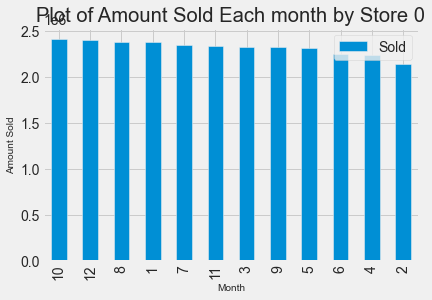

<Figure size 216x216 with 0 Axes>

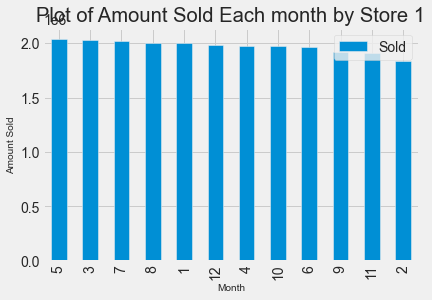

<Figure size 216x216 with 0 Axes>

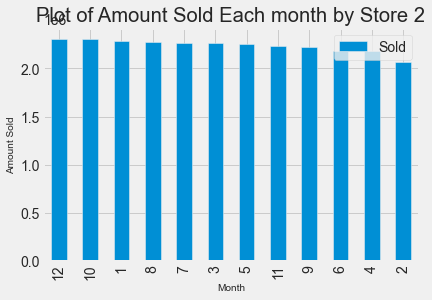

<Figure size 216x216 with 0 Axes>

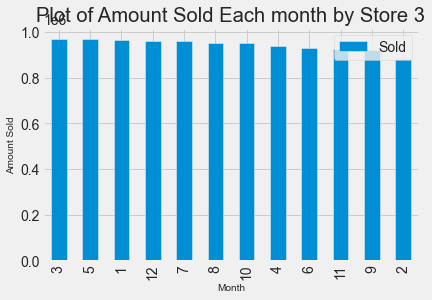

<Figure size 216x216 with 0 Axes>

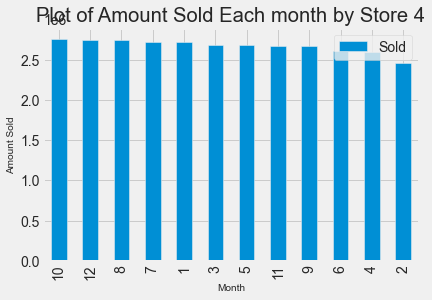

<Figure size 216x216 with 0 Axes>

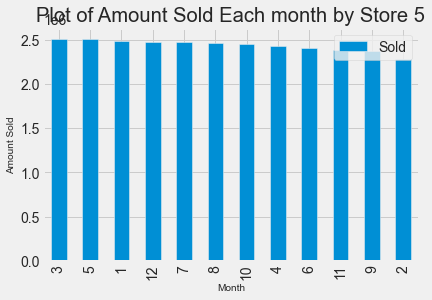

<Figure size 216x216 with 0 Axes>

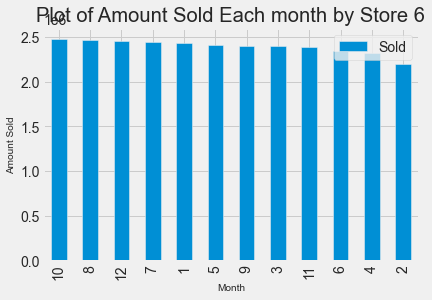

In [23]:
for i in range(train_df['Store'].nunique()):
    plot_storesale_month(i)
    print('')

### We will deal with each store individually

## Store 1

In [24]:
train_df.set_index('Date', inplace= True)

In [25]:
train_df.head()

,Store,Products,Sold,day,month,year,dayofweek
Date,,,,,,,
2010-01-01,0,0,801,1,1,2010,4
2010-01-02,0,0,810,2,1,2010,5
2010-01-03,0,0,818,3,1,2010,6
2010-01-04,0,0,796,4,1,2010,0
2010-01-05,0,0,808,5,1,2010,1


#### Lets us define a function which will create dataframe when provided with store information and product information.
#### this function will help us further in our analysis when we will need to predict prices of a particular product for particular store with the help of our model

In [26]:
def creating_df(store,products):
    store = int(store) 
    products = int(products)
    df=train_df[(train_df['Store']==store) & (train_df['Products']==products)]
    return df

Here are some data frames for store 1 with various products

In [27]:
s1p1 = creating_df(0,0)
s1p2 = creating_df(0,1)
s1p3 = creating_df(0,2)
s1p4 = creating_df(0,3)
s1p5 = creating_df(0,4)
s1p6 = creating_df(0,5)

### 1st product

In [28]:
## Store with product id 0
s1p1.head()

,Store,Products,Sold,day,month,year,dayofweek
Date,,,,,,,
2010-01-01,0,0,801,1,1,2010,4
2010-01-02,0,0,810,2,1,2010,5
2010-01-03,0,0,818,3,1,2010,6
2010-01-04,0,0,796,4,1,2010,0
2010-01-05,0,0,808,5,1,2010,1


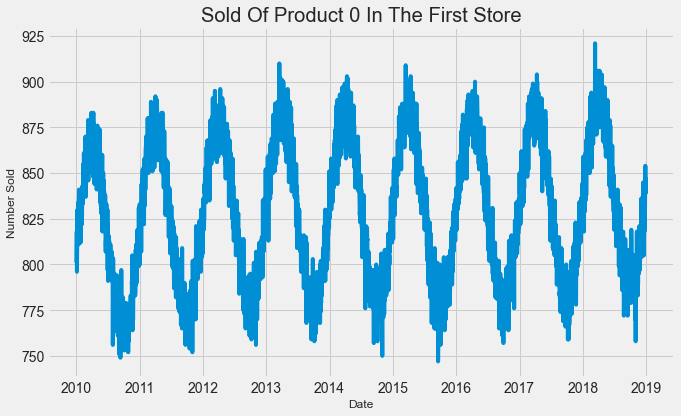

In [29]:
plt.figure(figsize = (10, 6))
plt.plot(s1p1.index, s1p1['Sold'])
plt.xlabel('Date', {'fontsize': 12})
plt.ylabel('Number Sold', {'fontsize': 12})
plt.title('Sold Of Product 0 In The First Store')
plt.show()
       

#### Analysis

From the above graph as we can see , sale of products '0' have been very stationary in the given time period.

### Ways to check if the given data is Stationery

### We can check whether a given time series is stationery or not using 2 tests , namely

1. Rolling Statistics

2. Augumented Dickey Fuller Test

### Rolling Statistics

This is more of a visual test

Here , we simply plot the moving average or variance of the given time series and try to observe if the plotted varies a lot with time

If average and variance do not change much with time , then our time series is stationery

In [30]:
average = s1p1['Sold'].dropna().rolling(window = 12).mean() #Rolling Average year
std = s1p1['Sold'].dropna().rolling(window = 12).std() #Rolling Standard Deviation

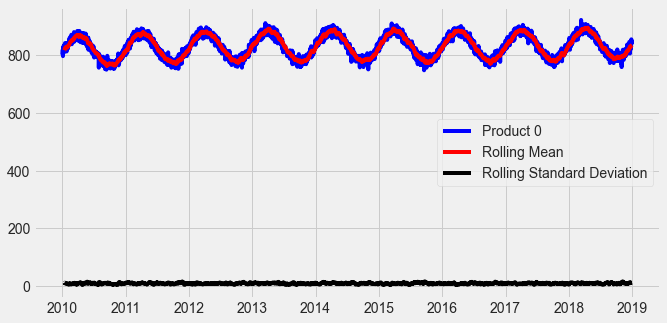

In [31]:
plt.figure(figsize = (10 , 5))
plt.plot(s1p1.index, s1p1['Sold'],c = 'b',label='Product 0')
plt.plot(average , c = 'r' , label = 'Rolling Mean' )
plt.plot(std , c = 'black' , label = 'Rolling Standard Deviation')
plt.legend()

#### It is clearly observable from the above Test that the given time series data is close to being stationary


### Let us scientifically confirm our above claim by using the famous Augumented Dickey Fuller Test

Augumented Dickey Fuller Test (ADF)

Let us assume a NULL Hypothesis H0 that the given time series is not stationary

Check the test statistic and values for different confidence intervals

If test statistic is < alpha value, reject the H0

Here , we take our confidence interval to be 95%

In [32]:
adf_test = adfuller(s1p1['Sold'])

In [33]:
print("Test Statistic : " , adf_test[0])
print("P Value : " , adf_test[1])

Test Statistic :  -5.05146490745594
P Value :  1.7536429088010104e-05


As our alpha value is 0.05 , and as p - value is  less than .05 , we not fail to reject our null hypotheses(N0)

Hence , we can now definitely confirm that our time series is  stationery.

### Trend and Seasonality

In [34]:
# Plotting seasonality and trend
def plot_timeseries(sales):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive')

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    plt.title('Decomposition Plots')

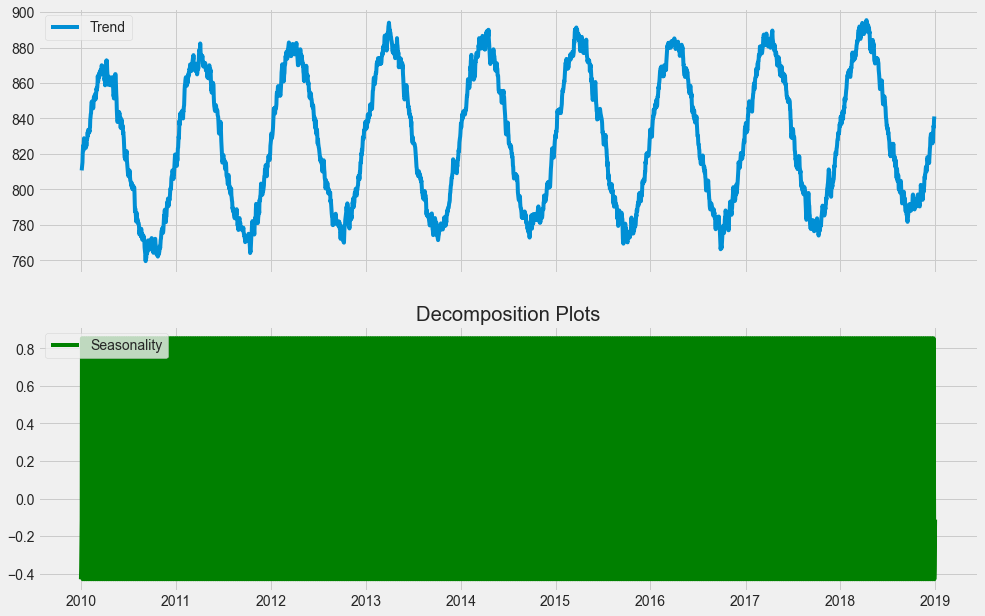

In [35]:
# Plotting seasonality and trend for Sales
plot_timeseries(s1p1['Sold'])

### Let's turn our DataFrame index and column into NumPy arrays.

In [36]:
# Get bitcoin date array
timesteps = s1p1.index.to_numpy()
prices = s1p1["Sold"].to_numpy()

timesteps[:10], prices[:10]

(array(['2010-01-01T00:00:00.000000000', '2010-01-02T00:00:00.000000000',
        '2010-01-03T00:00:00.000000000', '2010-01-04T00:00:00.000000000',
        '2010-01-05T00:00:00.000000000', '2010-01-06T00:00:00.000000000',
        '2010-01-07T00:00:00.000000000', '2010-01-08T00:00:00.000000000',
        '2010-01-09T00:00:00.000000000', '2010-01-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([801, 810, 818, 796, 808, 812, 830, 812, 817, 832], dtype=int64))

### Create train & test sets for time series (the right way)

In [37]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(s1p1)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train =timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2629, 658, 2629, 658)

In [38]:
X_train[:10],y_train[:10]

(array(['2010-01-01T00:00:00.000000000', '2010-01-02T00:00:00.000000000',
        '2010-01-03T00:00:00.000000000', '2010-01-04T00:00:00.000000000',
        '2010-01-05T00:00:00.000000000', '2010-01-06T00:00:00.000000000',
        '2010-01-07T00:00:00.000000000', '2010-01-08T00:00:00.000000000',
        '2010-01-09T00:00:00.000000000', '2010-01-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([801, 810, 818, 796, 808, 812, 830, 812, 817, 832], dtype=int64))

Okay, looks like our custom made splits are the same lengths as the splits we made with `train_test_split`.

But again, these are numbers on a page.

And you know how the saying goes, trust one eye more than two ears.

Let's visualize.

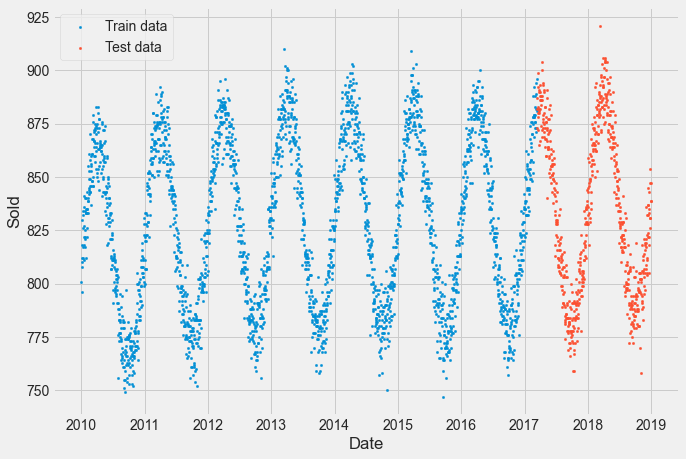

In [39]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Sold")
plt.legend(fontsize=14)
plt.show();

That looks much better!

Do you see what's happened here?

We're going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an *artificial* future, we can guage how our model might perform on *actual* future data.

### Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [40]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None,color = None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label,color = color)
  plt.xlabel("Time")
  plt.ylabel("Sold")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

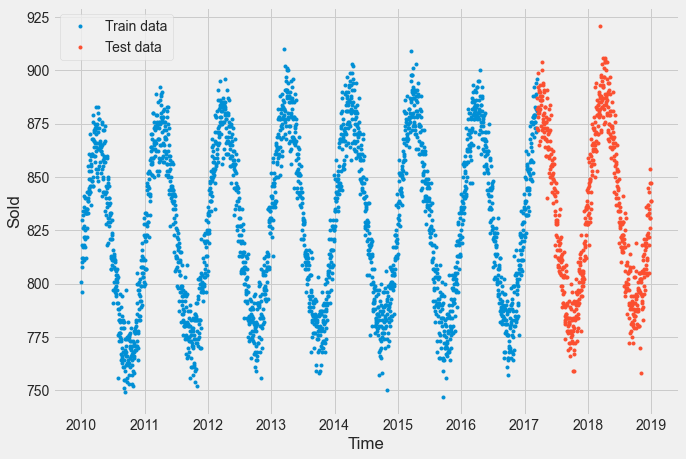

In [41]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

### MODEL 0: Building a Naive model(Base model)

As usual, let's start with a baseline.

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 

In English: 
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

In [42]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10 

(array([882, 887, 873, 872, 878, 899, 880, 883, 892, 880], dtype=int64),
 array([835, 843, 818, 826, 831, 831, 847, 854, 839, 847], dtype=int64))

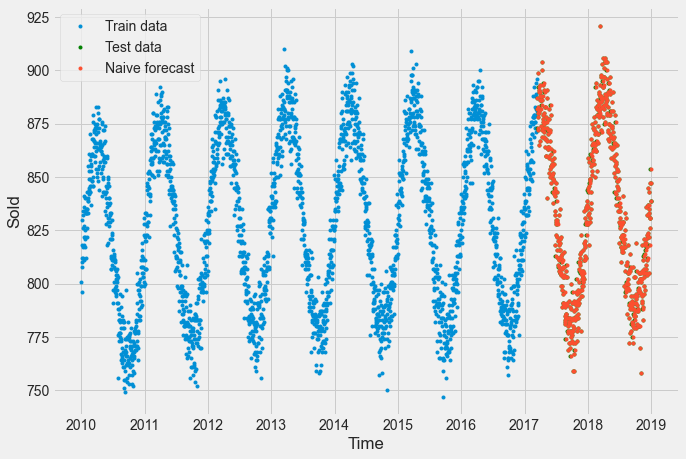

In [43]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data",format = '.',color = 'g')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format=".", label="Naive forecast");

The naive forecast looks like it's following the data well. 

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

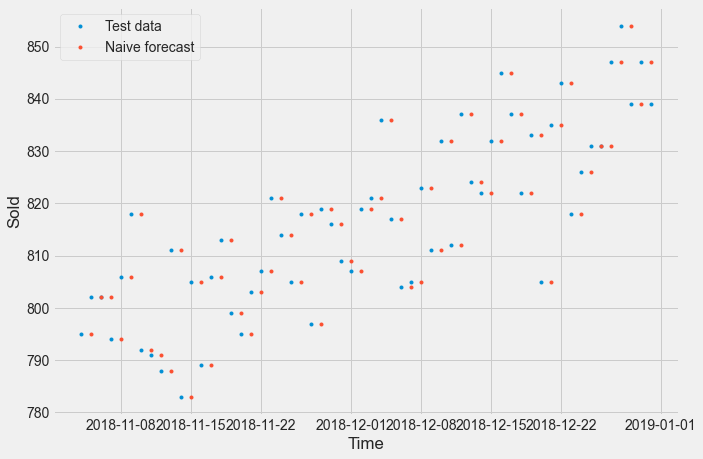

In [44]:
plt.figure(figsize=(10, 7))
offset = 600 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format=".", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a time series model

Time series forecasting often involves predicting a number (in our case, the price of products).
we can use regression metrics to evaluate our time series forecast.

The main thing we will be evaluating is: **how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or *ground truth values*)**? 

For all of the following metrics, **lower is better** (for example an MAE of 0 is better than an MAE 100).

Let's put each of our different evaluation metrics together into a function.

In [45]:
#!pip install tensorflow

In [46]:
# Let's get TensorFlow! 
import tensorflow as tf

In [47]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()
          }

Looking good! How about we test our function on the naive forecast?

In [48]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 11.508371, 'mse': 203.17656, 'rmse': 14.254002, 'mape': 1.3822844}

Alright, looks like we've got some baselines to beat.

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$11 different than the actual Sold price.

## Format Data Part 2: Windowing dataset

We've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```
Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7

In [49]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

Now we'll write a function to take in an array and turn it into a window and horizon.

In [50]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [51]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8



Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

In [52]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [53]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3280, 3280)

lets check first 3 and last 3 windows and their labels

In [54]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [801 810 818 796 808 812 830] -> Label: [812]
Window: [810 818 796 808 812 830 812] -> Label: [817]
Window: [818 796 808 812 830 812 817] -> Label: [832]


In [55]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [843 818 826 831 831 847 854] -> Label: [839]
Window: [818 826 831 831 847 854 839] -> Label: [847]
Window: [826 831 831 847 854 839 847] -> Label: [839]


> 🔑 **Note:** You can find a function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance .

## Turning windows into training and test sets 

Time to turn our windows into training and test splits.

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [56]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

Look at that amazing function, lets test it.

In [57]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2624, 656, 2624, 656)

Notice the default split of 80% training data and 20% testing data (this split can be adjusted if needed).

How do the first 5 samples of the training windows and labels looks?

In [58]:
train_windows[:5], train_labels[:5]

(array([[801, 810, 818, 796, 808, 812, 830],
        [810, 818, 796, 808, 812, 830, 812],
        [818, 796, 808, 812, 830, 812, 817],
        [796, 808, 812, 830, 812, 817, 832],
        [808, 812, 830, 812, 817, 832, 834]], dtype=int64),
 array([[812],
        [817],
        [832],
        [834],
        [826]], dtype=int64))

In [59]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Model 1: Dense model (window = 7, horizon = 1)

Finally!

Time to build one of our models.

Often, preparing data for a model is one of the largest parts of any machine learning project.

And once you've got a good model in place, you'll probably notice far more improvements from manipulating the data (e.g. collecting more, improving the quality) than manipulating the model.

We're going to start by keeping it simple, `model_1` will have:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 32
* 25 epochs

Why these values?

I picked them out of experimentation. 

A batch size of 32 works pretty well too and we could always train for less epochs but since the model runs so fast (you'll see in a second, it's because the number of samples we have isn't massive) we might as well train for more.

> 🔑 **Note:** As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called [**hyperparameters**](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning). And experimenting to find the best values for hyperparameters is called **hyperparameter tuning**. Where as parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as **parameters**.

Let's import TensorFlow and build our first deep learning model for time series.

In [60]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=25,
            verbose=1,
            batch_size=124,
            validation_data=(test_windows, test_labels))
            #callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/25
22/22 [==============================] - 12s 87ms/step - loss: 291.7223 - mae: 291.7223 - val_loss: 96.2476 - val_mae: 96.2476
Epoch 2/25
22/22 [==============================] - 0s 18ms/step - loss: 36.8528 - mae: 36.8528 - val_loss: 9.3963 - val_mae: 9.3963
Epoch 3/25
22/22 [==============================] - 0s 20ms/step - loss: 11.8059 - mae: 11.8059 - val_loss: 10.6980 - val_mae: 10.6980
Epoch 4/25
22/22 [==============================] - 0s 18ms/step - loss: 9.5569 - mae: 9.5569 - val_loss: 9.2617 - val_mae: 9.2617
Epoch 5/25
22/22 [==============================] - 0s 19ms/step - loss: 9.2595 - mae: 9.2595 - val_loss: 9.3188 - val_mae: 9.3188
Epoch 6/25
22/22 [==============================] - 0s 17ms/step - loss: 9.1336 - mae: 9.1336 - val_loss: 10.4384 - val_mae: 10.4384
Epoch 7/25
22/22 [==============================] - 0s 19ms/step - loss: 9.1226 - mae: 9.1226 - val_loss: 9.3474 - val_mae: 9.3474
Epoch 8/25
22/22 [==============================] - 0s 21ms/step - l

Let's evaluate our test_set

In [61]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

21/21 [==============================] - 1s 16ms/step - loss: 9.1262 - mae: 9.1262


[9.12619400024414, 9.12619400024414]

## Making forecasts with a model (on the test dataset)

We've trained a model and evaluated the it on the test data, but the project we're working on is about predicting sale price so how do you think we could use our model to make predictions?

Since we're going to be running more modelling experiments, let's write a function which: 
1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on) 
3. Passes the input data to the model's `predict()` method
4. Returns the predictions



In [62]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

Nice! 

Now let's use our `make_preds()` and see how it goes.



In [63]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

21/21 [==============================] - 1s 7ms/step


(656,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([887.256  , 883.98395, 880.2967 , 881.659  , 886.5928 , 882.5431 ,
        879.7633 , 877.3055 , 880.5275 , 884.9998 ], dtype=float32)>)

> 🔑 **Note:** With these outputs, our model isn't *forecasting* yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

Excellent! Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [64]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 9.126196, 'mse': 130.75876, 'rmse': 11.434979, 'mape': 1.0992835}

How did our model go? Did it beat the naïve forecast?

In [65]:
naive_results

{'mae': 11.508371, 'mse': 203.17656, 'rmse': 14.254002, 'mape': 1.3822844}

It looks like our deep model beats our naive model on nearly every metric , but our naive model was very close in battle.

That goes to show the power of the naïve model and the reason for having a baseline for any machine learning project.

And of course, no evaluation would be finished without visualizing the results.

Let's use the `plot_time_series()` function to plot `model_1_preds` against the test data.

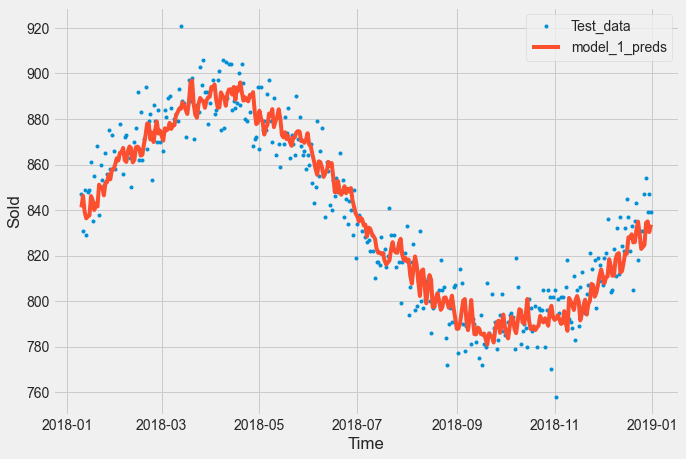

In [66]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.

With our current model setup, how do you think we'd make forecasts for the future?

Have a think about it for now, we'll cover this later on.

## Model 2: Dense (window = 30, horizon = 1)

Let's continue our modelling experiments.

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of prices to try and predict the next day price.

We'll start our second modelling experiment by preparing datasets using the functions we created earlier.

In [67]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [68]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3257, 3257)

In [69]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2605, 652, 2605, 652)

Data prepared!

Now let's construct `model_2`, a model with the same architecture as `model_1` as well as the same training routine.

In [70]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=98,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels))
            #callbacks=[create_model_checkpoint(model_name=model_2.name)])

Once again, training goes nice and fast.

Let's evaluate our model's performance.

In [71]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 9ms/step - loss: 8.7701


8.770108222961426

In [72]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

21/21 [==============================] - 0s 7ms/step


In [73]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 8.770109, 'mse': 122.52789, 'rmse': 11.069232, 'mape': 1.0556849}

It looks like `model_2` performs better than the naïve model as well 

How do the predictions look?

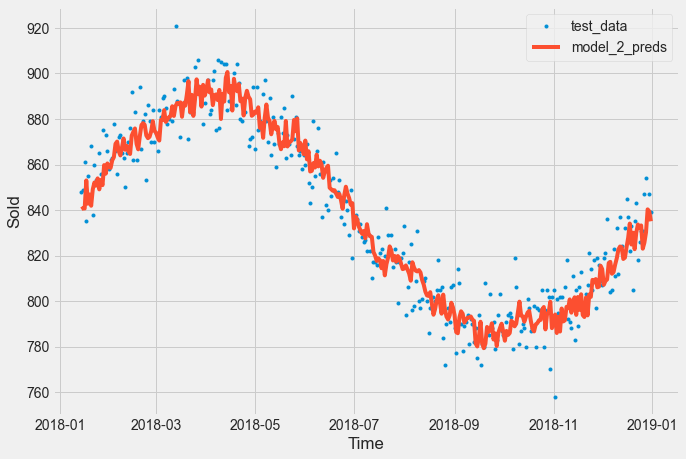

In [74]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.


In [75]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3251, 3251)

And we'll split the full dataset windows into training and test sets.

In [76]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2600, 651, 2600, 651)

Now let's build, compile, fit and evaluate a model.

In [77]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels))
            #callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [78]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 6ms/step - loss: 10.8719


10.871944427490234

In this case, the error will be higher because we're predicting 7 steps at a time. 

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

Let's make predictions with our model using the `make_preds()` function and evaluate them using the `evaluate_preds()` function.

In [79]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

21/21 [==============================] - 1s 14ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[889.1427 , 868.074  , 889.5348 , 882.345  , 888.80115, 884.58606,
        878.05035],
       [878.9183 , 867.7269 , 881.3361 , 875.2588 , 882.95636, 884.52216,
        869.98926],
       [885.45245, 876.475  , 885.29016, 878.5551 , 889.915  , 884.1819 ,
        876.55695],
       [877.8903 , 872.3944 , 876.56616, 877.263  , 883.62396, 884.6513 ,
        874.5135 ],
       [887.64844, 876.5139 , 878.8437 , 874.42834, 888.73627, 886.70544,
        877.5041 ]], dtype=float32)>

In [80]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 6.9547205,  9.108276 ,  6.9011927,  9.199995 ,  8.870336 ,
         6.418797 ,  8.934143 , 11.151525 , 10.860204 , 10.834115 ,
         7.9389563,  9.661891 , 13.6948595,  8.698076 , 10.907837 ,
         7.4555054,  7.5445294,  7.999163 ,  7.414856 ,  4.734253 ,
         9.916984 , 11.083531 , 13.03057  , 13.526664 , 12.173409 ,
        12.577567 , 13.653678 , 11.886824 ,  9.9914465, 11.484733 ,
        13.123143 ,  9.100377 ,  6.2473407,  9.5261755,  7.404855 ,
        12.053589 ,  9.718367 ,  8.401708 ,  4.968488 , 10.566232 ,
         8.90455  ,  9.443595 ,  7.6081195,  7.3614326, 10.15945  ,
         8.42402  , 12.240819 ,  9.611406 , 11.305281 ,  7.7581   ,
         8.172633 , 11.407889 , 12.64781  , 16.994986 , 15.511588 ,
        11.530762 , 11.572815 ,  8.451338 , 12.034215 ,  4.629525 ,
        11.652196 ,  8.504203 , 11.984139 , 11.846741 ,  7.538714 ,
        13.460502 ,  8.881993 , 11.106672 , 11.542079 ,  4.6273804,
        11.508275 ,  8.677604 , 12.591082

## Make our evaluation function work for larger horizons

You'll notice the outputs for `model_3_results` are multi-dimensional. 

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [83]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
 

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [84]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 10.871945, 'mse': 185.22984, 'rmse': 13.074418, 'mape': 1.3066607}

Time to visualize.

If our prediction evaluation metrics were mutli-dimensional, how do you think the predictions will look like if we plot them?

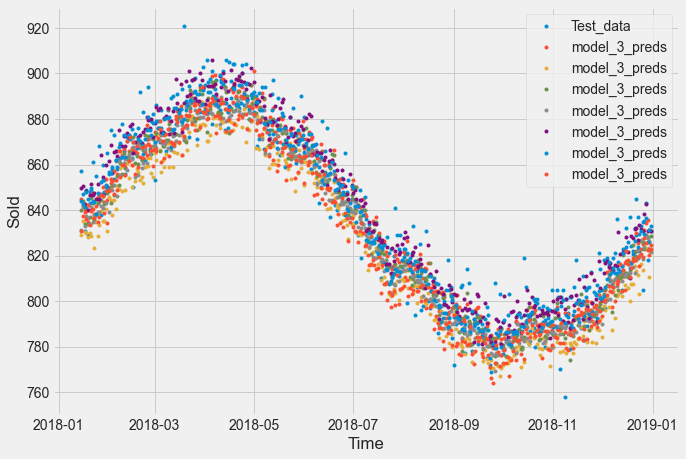

In [85]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

When we try to plot our multi-horizon predicts, we get a funky looking plot.

Again, we can fix this by aggregating our model's predictions.

> 🔑 **Note:** Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

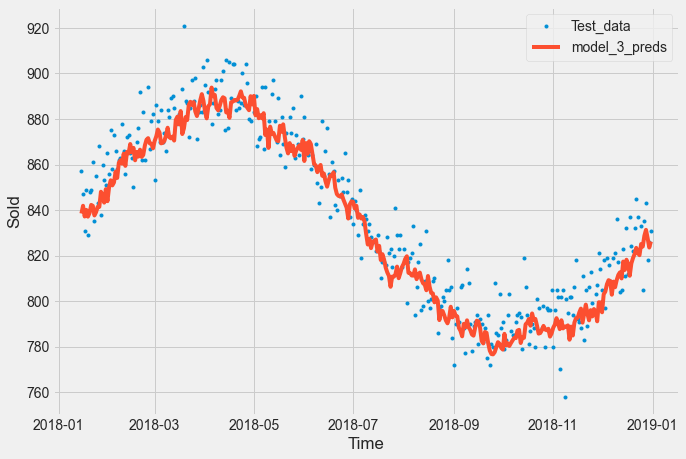

In [86]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

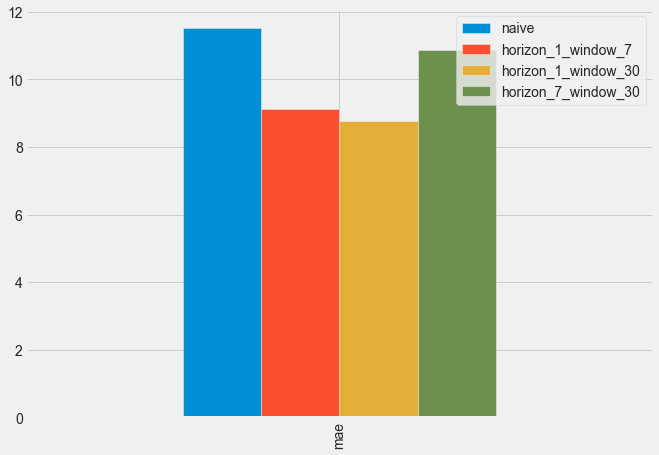

In [87]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

## conclusion

we have performed 3 different models based on different horixons and windows size ,usually naive models performs good in many 
cases  due the presence of **autocorrelation** in the data. If a time series has **autocorrelation** it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value.But in our case model  with `Horizon = 1` and `Windows = 30` performed well out of 
all 4 models and gave minimum mae.